In [1]:
import numpy as np
import matplotlib.pyplot as plt


In [2]:
def f(x):
    return (x[0] + 5 * x[1]) ** 2 + (x[1] - 1) ** 2


def rosenbrock(x):
    return (1 - x[0]) ** 2 + 100 * (x[1] - x[0] ** 2) ** 2


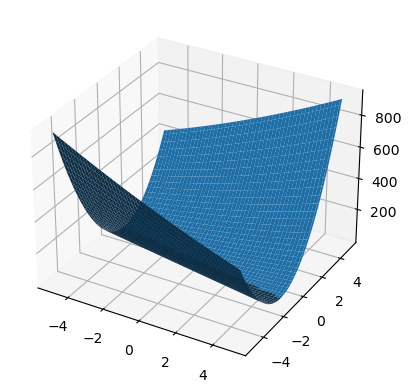

In [3]:
ax = plt.axes(projection="3d")
X = np.linspace(-5.0, 5.0, 100)
Y = np.linspace(-5.0, 5.0, 100)
X, Y = np.meshgrid(X, Y)
Z = f([X, Y])
ax.plot_surface(X, Y, Z)


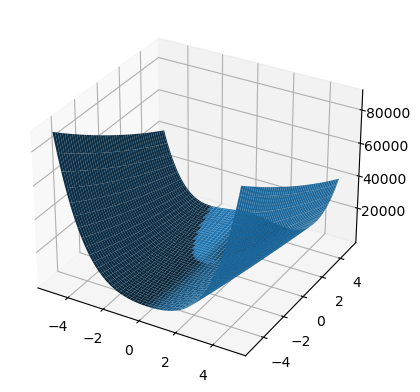

In [4]:
ax = plt.axes(projection="3d")
X = np.linspace(-5.0, 5.0, 100)
Y = np.linspace(-5.0, 5.0, 100)
X, Y = np.meshgrid(X, Y)
Z = rosenbrock([X, Y])
ax.plot_surface(X, Y, Z)


In [5]:
EPS = 10 ** (-6)


def onehot(n, i):
    return np.identity(n)[i]


def deriv(f, i):
    return lambda x: (
        f(x + EPS * onehot(len(x), i)) - f(x - EPS * onehot(len(x), i))
    ) / (2 * EPS)


def grad(f):
    return lambda x: np.array([deriv(f, i)(x) for i in range(len(x))])


def hessian(f):
    def wrapped(x):
        res = []
        for i in range(len(x)):
            res.append([])
            for j in range(len(x)):
                res[-1].append(deriv(deriv(f, i), j)(x))
        return np.array(res)

    return wrapped


def golden_section_search(f, l, r):
    phi = (1 + np.sqrt(5)) / 2
    revphi = 2 - phi
    x1 = l + revphi * (r - l)
    x2 = r - revphi * (r - l)
    f1 = f(x1)
    f2 = f(x2)
    dots = []
    while abs(r - l) > EPS:
        dots.append((x1 + x2) / 2)
        if f1 < f2:
            r = x2
            x2 = x1
            f2 = f1
            x1 = l + revphi * (r - l)
            f1 = f(x1)
        else:
            l = x1
            x1 = x2
            f1 = f2
            x2 = r - revphi * (r - l)
            f2 = f(x2)
    dots.append((x1 + x2) / 2)
    return dots


def svenn(f, x0):
    h = 10 ** (-6)
    if f(x0 + h) > f(x0):
        h *= -1
    points = [x0, x0 + h]
    while f(points[-1]) < f(points[-2]):
        h *= 2
        points.append(points[-1] + h)
    if h < 0:
        return (points[-1], points[-3])
    return (points[-3], points[-1])


In [6]:
def newton(f, x0, eps):
    df = grad(f)
    H = hessian(f)

    res = []
    x = x0
    while True:
        res.append(x)
        new_x = x - np.linalg.inv(H(x)) @ df(x)
        if np.linalg.norm(new_x - x) < eps:
            break
        x = new_x

    return res


In [7]:
def broyden(f, x0, eps):
    res = []
    x = x0
    eta = np.identity(len(x0))
    grad_f = grad(f)
    while True:
        res.append(x)
        nabla_f = grad_f(x)
        fopt = lambda lmbda: f(x - lmbda * eta @ nabla_f)
        _, r = svenn(fopt, 0)
        lmbda = golden_section_search(fopt, 0, r)[-1]
        new_x = x - lmbda * eta @ nabla_f
        if np.linalg.norm(new_x - x) < eps:
            break
        delta_x = new_x - x
        delta_g = grad_f(new_x) - nabla_f

        delta_eta = np.outer(
            (delta_x - eta @ delta_g), (delta_x - eta @ delta_g)
        ) / np.dot(delta_x - eta @ delta_g, delta_g)

        eta += delta_eta
        x = new_x
    return res


In [8]:
def dfp(f, x0, eps):
    res = []
    x = x0
    eta = np.identity(len(x0))
    grad_f = grad(f)
    while True:
        res.append(x)
        nabla_f = grad_f(x)
        fopt = lambda lmbda: f(x - lmbda * eta @ nabla_f)
        _, r = svenn(fopt, 0)
        lmbda = golden_section_search(fopt, 0, r)[-1]
        new_x = x - lmbda * eta @ nabla_f
        if np.linalg.norm(new_x - x) < eps:
            break
        delta_x = new_x - x
        delta_g = grad_f(new_x) - nabla_f

        delta_eta = np.outer(delta_x, delta_x) / np.dot(delta_x, delta_g) - (
            eta @ np.outer(delta_g, delta_g) @ np.transpose(eta)
        ) / np.dot(delta_g, eta @ delta_g)

        eta += delta_eta
        x = new_x
    return res


In [9]:
def bfgs(f, x0, eps):
    n = len(x0)
    E = np.identity(n)
    res = []
    x = x0
    eta = E
    grad_f = grad(f)
    while True:
        res.append(x)
        nabla_f = grad_f(x)
        fopt = lambda lmbda: f(x - lmbda * eta @ nabla_f)
        _, r = svenn(fopt, 0)
        lmbda = golden_section_search(fopt, 0, r)[-1]
        new_x = x - lmbda * eta @ nabla_f
        if np.linalg.norm(new_x - x) < eps:
            break
        delta_x = new_x - x
        delta_g = grad_f(new_x) - nabla_f

        rho = 1/np.dot(delta_g, delta_x)
        eta = (E - rho*np.outer(delta_x, delta_g)) @ eta @ (E - rho*np.outer(delta_g, delta_x)) + rho*np.outer(delta_x, delta_x)

        x = new_x
    return res


In [11]:
F_START = np.array([8, 10])
F_PRECISION = 0.35

ROSENBROCK_START = np.array([1.5, 1.5])
ROSENBROCK_PRECISION = 0.001


In [12]:
newton(f, F_START, F_PRECISION)


[array([ 8, 10]),
 array([18.65680329, -3.53245046]),
 array([-5.21850413,  1.0420044 ])]

In [13]:
newton(rosenbrock, ROSENBROCK_START, ROSENBROCK_PRECISION)


[array([1.5, 1.5]),
 array([1.49668439, 2.24005314]),
 array([1.001099  , 0.75659434]),
 array([1.00107719, 1.00215552]),
 array([1.        , 0.99999885])]

In [14]:
broyden(f, F_START, F_PRECISION)


[array([ 8, 10]),
 array([ 5.84890182, -1.08928201]),
 array([-5.00008567,  0.99943706])]

In [15]:
broyden(rosenbrock, ROSENBROCK_START, ROSENBROCK_PRECISION)


[array([1.5, 1.5]),
 array([1.25696516, 1.58083199]),
 array([1.24560205, 1.54671791]),
 array([1.16105655, 1.3374954 ]),
 array([1.07913616, 1.17088995]),
 array([1.06185509, 1.13098822]),
 array([1.02753453, 1.05429391]),
 array([1.00406022, 1.00655294]),
 array([1.00379748, 1.00761566]),
 array([1.00001583, 1.00001541])]

In [16]:
dfp(f, F_START, F_PRECISION)


[array([ 8, 10]),
 array([ 5.84890182, -1.08928201]),
 array([-5.00008573,  0.99943707])]

In [17]:
dfp(rosenbrock, ROSENBROCK_START, ROSENBROCK_PRECISION)


[array([1.5, 1.5]),
 array([1.25696516, 1.58083199]),
 array([1.24560205, 1.54671791]),
 array([1.16105653, 1.33749535]),
 array([1.07913924, 1.1708964 ]),
 array([1.03767799, 1.07516289]),
 array([1.01475525, 1.02726682]),
 array([1.00711864, 1.01449614]),
 array([1.00062052, 1.00112999]),
 array([1.00003704, 1.00007599])]

In [18]:
bfgs(f, F_START, F_PRECISION)

[array([ 8, 10]),
 array([ 5.84890182, -1.08928201]),
 array([-5.00008581,  0.99943709])]

In [19]:
bfgs(rosenbrock, ROSENBROCK_START, ROSENBROCK_PRECISION)

[array([1.5, 1.5]),
 array([1.25696516, 1.58083199]),
 array([1.24560205, 1.5467179 ]),
 array([1.1610565 , 1.33749529]),
 array([0.93753256, 0.88290392]),
 array([0.93226505, 0.87049939]),
 array([0.983831  , 0.96641958]),
 array([0.99835532, 0.99687731]),
 array([0.99987627, 0.99974192])]